In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [2]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data_sub/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_25022020/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_25022020/sim_samples/"

readlen = 101

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
# Here we need to implement a method for converting TPM information into
# coverage information for polyester
# we can do this by following the REM implementation of the TPM to number of reads conversion

# first load the distribution of the number of reads per sample
readlen_stats = pd.read_csv("/ccb/salz8-1/avaraby/tx_noise/readlen.stats",usecols=["readlen"])

In [17]:
i=0
total_nreads = np.random.normal(readlen_stats["readlen"].mean(),readlen_stats["readlen"].std())
print("number of reads in sample is: "+str(total_nreads))

real = pd.read_csv(out_dir+"real.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
real["tid"] = real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
real["gid"] = real["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
realt = real[real["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
reale = real[real["type"]=="exon"].reset_index(drop=True)
reale["elen"] = reale["end"]-reale["start"]
reale = reale[["tid","elen"]]
reale = reale.groupby("tid").agg({"elen":"sum"}).reset_index()
assert set(realt["tid"])==set(reale["tid"]),"number of transcripts is not the same as number of groupped exons"
reale = realt.merge(reale,how="left",on="tid")
tpms = pd.read_csv(out_dir+"real.sample"+str(i)+".exp",names=["tpm"])
assert len(tpms)==len(reale),"number of tpms different from the number of transcripts"
reale["tpm"] = tpms["tpm"]

splicing = pd.read_csv(out_dir+"splicing.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
splicing["tid"] = splicing["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
splicing["gid"] = splicing["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
splicingt = splicing[splicing["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
splicinge = splicing[splicing["type"]=="exon"].reset_index(drop=True)
splicinge["elen"] = splicinge["end"]-splicinge["start"]
splicinge = splicinge[["tid","elen"]]
splicinge = splicinge.groupby("tid").agg({"elen":"sum"}).reset_index()
assert set(splicingt["tid"])==set(splicinge["tid"]),"number of transcripts is not the same as number of groupped exons"
splicinge = splicingt.merge(splicinge,how="left",on="tid")
tpms = pd.read_csv(out_dir+"splicing.sample"+str(i)+".exp",names=["tpm"])
assert len(tpms)==len(splicinge),"number of tpms different from the number of transcripts"
splicinge["tpm"] = tpms["tpm"]

intronic = pd.read_csv(out_dir+"intronic.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
intronic["tid"] = intronic["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
intronic["gid"] = intronic["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
intronict = intronic[intronic["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
intronice = intronic[intronic["type"]=="exon"].reset_index(drop=True)
intronice["elen"] = intronice["end"]-intronice["start"]
intronice = intronice[["tid","elen"]]
intronice = intronice.groupby("tid").agg({"elen":"sum"}).reset_index()
assert set(intronict["tid"])==set(intronice["tid"]),"number of transcripts is not the same as number of groupped exons"
intronice = intronict.merge(intronice,how="left",on="tid")
tpms = pd.read_csv(out_dir+"intronic.sample"+str(i)+".exp",names=["tpm"])
assert len(tpms)==len(intronice),"number of tpms different from the number of transcripts"
intronice["tpm"] = tpms["tpm"]

pol = pd.read_csv(out_dir+"pol.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
pol["tid"] = pol["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
pol["gid"] = pol["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
polt = pol[pol["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
pole = pol[pol["type"]=="exon"].reset_index(drop=True)
pole["elen"] = pole["end"]-pole["start"]
pole = pole[["tid","elen"]]
pole = pole.groupby("tid").agg({"elen":"sum"}).reset_index()
assert set(polt["tid"])==set(pole["tid"]),"number of transcripts is not the same as number of groupped exons"
pole = polt.merge(pole,how="left",on="tid")

tpms = pd.read_csv(out_dir+"pol.sample"+str(i)+".exp",names=["tpm"])
assert len(tpms)==len(pole),"number of tpms different from the number of transcripts"
pole["tpm"] = tpms["tpm"]
joined = pd.concat([reale[["tid","elen","tpm"]],splicinge[["tid","elen","tpm"]],intronice[["tid","elen","tpm"]],pole[["tid","elen","tpm"]]],axis=0).reset_index(drop=True)
joined["theta"] = joined["elen"]*joined["tpm"]
denom = joined["theta"].sum()
joined["cor"] = joined["theta"]/denom
# tids = np.random.choice(joined["tid"],total_nreads,p=joined["cor"])
# tid_df = pd.DataFrame(tids,columns=["tid"]).groupby("tid").agg({"tid":{"count":"count"}}).reset_index()
# tid_df.columns = ["tid","count"]
# now that we have all these values, we 
joined["cov"] = (joined["cor"]*total_nreads*readlen)/joined["elen"]
# now we can merge the data to comply with the original ordering
# and proceed to write it out
realt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"real.sample"+str(i)+".exp2",index=False,header=False)
splicingt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"splicing.sample"+str(i)+".exp2",index=False,header=False)
intronict.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"intronic.sample"+str(i)+".exp2",index=False,header=False)
polt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"pol.sample"+str(i)+".exp2",index=False,header=False)

number of reads in sample is: 53301782.7301581


In [18]:
# first need to compute total contribution of each to the gene
realg = reale[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
realg.columns = ["gid","nt_real","tpm_real"]
splicingg = splicinge[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
splicingg.columns = ["gid","nt_splicing","tpm_splicing"]
intronicg = intronice[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
intronicg.columns = ["gid","nt_intronic","tpm_intronic"]
joined = realg.merge(splicingg,on="gid",how="outer",indicator=True)
joined["nt_real"] = joined["nt_real"].fillna(0)
joined["tpm_real"] = joined["tpm_real"].fillna(0)
joined.drop("_merge",axis=1,inplace=True)
joined = joined.merge(intronicg,on="gid",how="outer",indicator=True)
joined["nt_real"] = joined["nt_real"].fillna(0)
joined["tpm_real"] = joined["tpm_real"].fillna(0)
joined.drop("_merge",axis=1,inplace=True)
joined["nt_splicing"] = joined.nt_splicing.fillna(0)
joined["tpm_splicing"] = joined.tpm_splicing.fillna(0)
joined["nt_intronic"] = joined.nt_intronic.fillna(0)
joined["tpm_intronic"] = joined.tpm_intronic.fillna(0)
joined["nt_total"] = joined.nt_real+joined.nt_splicing+joined.nt_intronic
joined["tpm_total"] = joined.tpm_real+joined.tpm_splicing+joined.tpm_intronic
joined["frac"] = joined["tpm_real"]/(joined["tpm_real"]+joined["tpm_splicing"])
joined["frac_tpm_real"] = joined.tpm_real/joined.tpm_total
joined["frac_tpm_splicing"] = joined.tpm_splicing/joined.tpm_total
joined["frac_tpm_intronic"] = joined.tpm_intronic/joined.tpm_total
joined["total_tpm_noise"] = joined["tpm_splicing"]+joined["tpm_intronic"]
joined.head()

,gid,nt_real,tpm_real,nt_splicing,tpm_splicing,nt_intronic,tpm_intronic,nt_total,tpm_total,frac,frac_tpm_real,frac_tpm_splicing,frac_tpm_intronic,total_tpm_noise
0,CHS.10002,2.0,2.362163,0.0,0.000000,0.0,0.00000,2.0,2.362163,1.000000,1.000000,0.000000,0.000000,0.000000
1,CHS.10003,1.0,0.134527,5.0,12.148045,2.0,2.99928,8.0,15.281851,0.010953,0.008803,0.794933,0.196264,15.147325
2,CHS.10005,2.0,5.013131,0.0,0.000000,0.0,0.00000,2.0,5.013131,1.000000,1.000000,0.000000,0.000000,0.000000
3,CHS.10008,2.0,0.566382,0.0,0.000000,0.0,0.00000,2.0,0.566382,1.000000,1.000000,0.000000,0.000000,0.000000
4,CHS.10009,1.0,0.341627,0.0,0.000000,0.0,0.00000,1.0,0.341627,1.000000,1.000000,0.000000,0.000000,0.000000


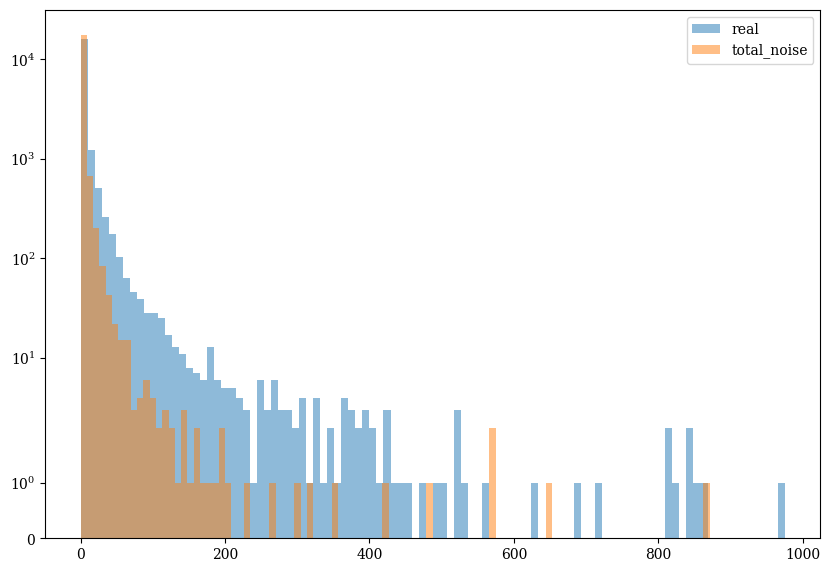

In [19]:
fig = plt.subplots(figsize=(10,7),dpi=100)
plt.hist(joined[(joined["tpm_real"]<1000)]["tpm_real"],bins=100,alpha=0.5,label='real')
plt.hist(joined[(joined["total_tpm_noise"]<1000)]["total_tpm_noise"],bins=100,alpha=0.5,label='total_noise')
plt.yscale("symlog")
plt.legend(loc='upper right')

In [39]:
# what does it look like on the real data


# need to get the same numbers for the real data and make sure they are consistent
#  1. total fraction of real expression per sample
#  2. fraction of real expression in genes with splicing and/or intronic noise
#  3. total contribution of real vs noise to expression of cell

In [7]:
sample_stats = pd.read_csv(base_dir_out+"res.num_tx_per_sample_loc5")
sample_stats["frac_real"] = sample_stats["total_tpm_real"]/(sample_stats["total_tpm_real"]+\
                                                            sample_stats["total_tpm_splicing"]+\
                                                            sample_stats["total_tpm_intronic"])
sample_stats["total_noise"] = sample_stats["total_tpm_splicing"]+sample_stats["total_tpm_intronic"]
total_real = sample_stats["total_tpm_real"].sum()
total_real_noise = sample_stats["total_tpm_splicing"].sum()+sample_stats["total_tpm_intronic"].sum()
total_intergenic_noise = sample_stats["total_tpm_polymerase"].sum()

print("fraction of real expression per sample on average: "+str(total_real/(total_intergenic_noise+total_real_noise+total_real)))




FileNotFoundError: [Errno 2] File b'/ccb/salz8-1/avaraby/tx_noise/full_analysis_25022020/GTEx_aggs/res.num_tx_per_sample_loc5' does not exist: b'/ccb/salz8-1/avaraby/tx_noise/full_analysis_25022020/GTEx_aggs/res.num_tx_per_sample_loc5'

In [20]:
er = joined["tpm_real"].sum()
print("total real expression: "+str(er))
es = joined["tpm_splicing"].sum()
print("total splicing expression: "+str(es))
ei = joined["tpm_intronic"].sum()
print("total intronic expression: "+str(ei))
ep = pole.tpm.sum()
print("total polymerase expression: "+str(ep))
print("fraction of real expression: "+str(er/(er+es+ei+ep)))

total real expression: 305163.7665832051
total splicing expression: 82392.65604848394
total intronic expression: 2986.2175629383746
total polymerase expression: 2119.3822829752944
fraction of real expression: 0.7771664920831796


In [21]:
# is it because there are many real_only loci?
print("number of loci: "+str(len(set(joined["gid"]))))
print("number of real only loci: "+str(len(set(joined[(joined["nt_splicing"]==0)&(joined["nt_intronic"]==0)]["gid"]))))

number of loci: 18629
number of real only loci: 9679


In [22]:
er = joined[(joined["nt_splicing"]>0)|(joined["nt_intronic"]>0)]["tpm_real"].sum()
print("total real expression: "+str(er))
es = joined[(joined["nt_splicing"]>0)|(joined["nt_intronic"]>0)]["tpm_splicing"].sum()
print("total splicing expression: "+str(es))
ei = joined[(joined["nt_splicing"]>0)|(joined["nt_intronic"]>0)]["tpm_intronic"].sum()
print("total intronic expression: "+str(ei))
print("fraction of real expression: "+str(er/(er+es+ei)))

total real expression: 96829.19721836215
total splicing expression: 82392.65604848393
total intronic expression: 2986.217562938375
fraction of real expression: 0.5314210110309453


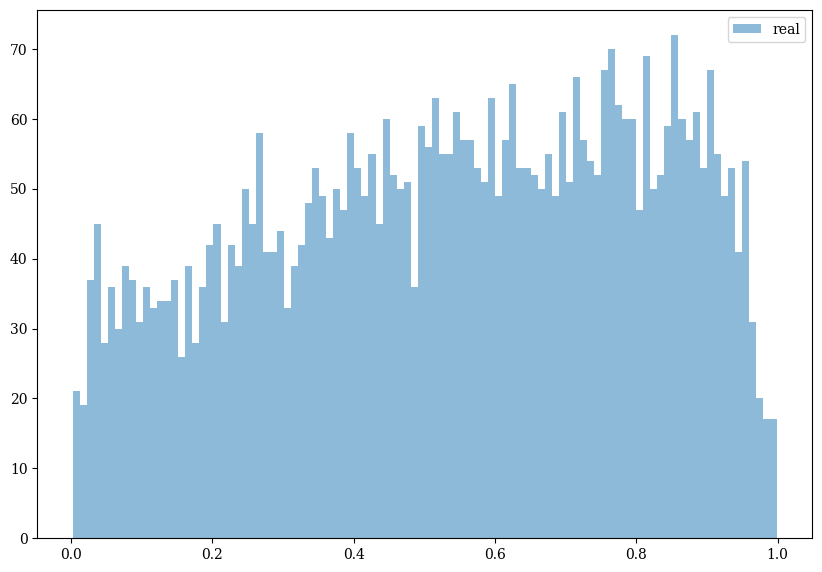

In [23]:
# fig = plt.subplots(figsize=(10,7),dpi=100)
# # plt.hist(joined[joined["frac"]<1.0]["frac"],alpha=0.5,bins=100,label='real')
# plt.hist(joined[(joined["frac_tpm_real"]>0.0001)]["frac_tpm_real"],alpha=0.5,bins=100,label='real')
# plt.hist(joined[(joined["frac_tpm_splicing"]>0.0001)]["frac_tpm_splicing"],alpha=0.5,bins=100,label='splicing')
# plt.hist(joined[(joined["frac_tpm_intronic"]>0.0001)]["frac_tpm_intronic"],alpha=0.5,bins=100,label='intronic')
# plt.legend(loc='upper right')


fig = plt.subplots(figsize=(10,7),dpi=100)
# plt.hist(joined[joined["frac"]<1.0]["frac"],alpha=0.5,bins=100,label='real')
plt.hist(joined[(joined["frac_tpm_real"]>0.0001)&(joined["frac_tpm_real"]<1.0)]["frac_tpm_real"],alpha=0.5,bins=100,label='real')
# plt.hist(joined[(joined["frac_tpm_splicing"]>0.0001)&(joined["frac_tpm_splicing"]<1.0)]["frac_tpm_splicing"],alpha=0.5,bins=100,label='splicing')
# plt.hist(joined[(joined["frac_tpm_intronic"]>0.0001)&(joined["frac_tpm_intronic"]<1.0)]["frac_tpm_intronic"],alpha=0.5,bins=100,label='intronic')
plt.legend(loc='upper right')